<a id='1'></a>
# 1. Import packages

In [2]:
from keras.models import Sequential, Model
from keras.layers import *
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import relu
from keras.initializers import RandomNormal
from keras.applications import *
import keras.backend as K
from tensorflow.contrib.distributions import Beta
import tensorflow as tf
from keras.optimizers import Adam

/home/bryan/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
from image_augmentation import random_transform
from image_augmentation import random_warp
from utils import get_image_paths, load_images, stack_images
from pixel_shuffler import PixelShuffler

In [4]:
import time
import numpy as np
from PIL import Image
import cv2
import glob
from random import randint, shuffle
from IPython.display import clear_output
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '13'

<a id='4'></a>
# 4. Config

mixup paper: https://arxiv.org/abs/1710.09412

Default training data directories: `./faceA/` and `./faceB/`

In [6]:
K.set_learning_phase(0)

In [7]:
channel_axis=-1
channel_first = False

In [8]:
IMAGE_SHAPE = (64, 64, 3)
nc_in = 3 # number of input channels of generators
nc_D_inp = 6 # number of input channels of discriminators

use_self_attn = False
w_l2 = 1e-4 # weight decay

batchSize = 8

# Path of training images
img_dirA = './faceA/*.*'
img_dirB = './faceB/*.*'

<a id='5'></a>
# 5. Define models

In [9]:
conv_init = 'he_normal'

In [10]:
class Scale(Layer):
    '''
    Code borrows from https://github.com/flyyufelix/cnn_finetune
    '''
    def __init__(self, weights=None, axis=-1, gamma_init='zero', **kwargs):
        self.axis = axis
        self.gamma_init = initializers.get(gamma_init)
        self.initial_weights = weights
        super(Scale, self).__init__(**kwargs)

    def build(self, input_shape):
        self.input_spec = [InputSpec(shape=input_shape)]

        # Compatibility with TensorFlow >= 1.0.0
        self.gamma = K.variable(self.gamma_init((1,)), name='{}_gamma'.format(self.name))
        self.trainable_weights = [self.gamma]

        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights

    def call(self, x, mask=None):
        return self.gamma * x

    def get_config(self):
        config = {"axis": self.axis}
        base_config = super(Scale, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


def self_attn_block(inp, nc):
    '''
    Code borrows from https://github.com/taki0112/Self-Attention-GAN-Tensorflow
    '''
    assert nc//8 > 0, "Input channels must be >= 8, but got nc={nc}".format(nc=nc)
    x = inp
    shape_x = x.get_shape().as_list()
    
    f = Conv2D(nc//8, 1, kernel_initializer=conv_init)(x)
    g = Conv2D(nc//8, 1, kernel_initializer=conv_init)(x)
    h = Conv2D(nc, 1, kernel_initializer=conv_init)(x)
    
    shape_f = f.get_shape().as_list()
    shape_g = g.get_shape().as_list()
    shape_h = h.get_shape().as_list()
    flat_f = Reshape((-1, shape_f[-1]))(f)
    flat_g = Reshape((-1, shape_g[-1]))(g)
    flat_h = Reshape((-1, shape_h[-1]))(h)   
    
    s = Lambda(lambda x: tf.matmul(x[0], x[1], transpose_b=True))([flat_g, flat_f])

    beta = Softmax(axis=-1)(s)
    o = Lambda(lambda x: tf.matmul(x[0], x[1]))([beta, flat_h])
    o = Reshape(shape_x[1:])(o)
    o = Scale()(o)
    
    out = add([o, inp])
    return out

def conv_block(input_tensor, f):
    x = input_tensor
    x = Conv2D(f, kernel_size=3, strides=2, kernel_regularizer=regularizers.l2(w_l2),  
               kernel_initializer=conv_init, use_bias=False, padding="same")(x)
    x = Activation("relu")(x)
    return x

def conv_block_d(input_tensor, f, use_instance_norm=False):
    x = input_tensor
    x = Conv2D(f, kernel_size=4, strides=2, kernel_regularizer=regularizers.l2(w_l2), 
               kernel_initializer=conv_init, use_bias=False, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def res_block(input_tensor, f):
    x = input_tensor
    x = Conv2D(f, kernel_size=3, kernel_regularizer=regularizers.l2(w_l2), 
               kernel_initializer=conv_init, use_bias=False, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(f, kernel_size=3, kernel_regularizer=regularizers.l2(w_l2), 
               kernel_initializer=conv_init, use_bias=False, padding="same")(x)
    x = add([x, input_tensor])
    x = LeakyReLU(alpha=0.2)(x)
    return x

def upscale_ps(filters, use_norm=True):
    def block(x):
        x = Conv2D(filters*4, kernel_size=3, kernel_regularizer=regularizers.l2(w_l2), 
                   kernel_initializer=RandomNormal(0, 0.02), padding='same')(x)
        x = LeakyReLU(0.2)(x)
        x = PixelShuffler()(x)
        return x
    return block

def Discriminator(nc_in, input_size=64):
    inp = Input(shape=(input_size, input_size, nc_in))
    #x = GaussianNoise(0.05)(inp)
    x = conv_block_d(inp, 64, False)
    x = conv_block_d(x, 128, False)
    x = self_attn_block(x, 128) if use_self_attn else x
    x = conv_block_d(x, 256, False)
    x = self_attn_block(x, 256) if use_self_attn else x
    out = Conv2D(1, kernel_size=4, kernel_initializer=conv_init, use_bias=False, padding="same")(x)   
    return Model(inputs=[inp], outputs=out)

def Encoder(nc_in=3, input_size=64):
    inp = Input(shape=(input_size, input_size, nc_in))
    x = Conv2D(64, kernel_size=5, kernel_initializer=conv_init, use_bias=False, padding="same")(inp)
    x = conv_block(x,128)
    x = conv_block(x,256)
    x = self_attn_block(x, 256) if use_self_attn else x
    x = conv_block(x,512) 
    x = self_attn_block(x, 512) if use_self_attn else x
    x = conv_block(x,1024)
    x = Dense(1024)(Flatten()(x))
    x = Dense(4*4*1024)(x)
    x = Reshape((4, 4, 1024))(x)
    out = upscale_ps(512)(x)
    return Model(inputs=inp, outputs=out)

def Decoder_ps(nc_in=512, input_size=8):
    input_ = Input(shape=(input_size, input_size, nc_in))
    x = input_
    x = upscale_ps(256)(x)
    x = upscale_ps(128)(x)
    x = self_attn_block(x, 128) if use_self_attn else x
    x = upscale_ps(64)(x)
    x = res_block(x, 64)
    x = self_attn_block(x, 64) if use_self_attn else x
    #x = Conv2D(4, kernel_size=5, padding='same')(x)   
    alpha = Conv2D(1, kernel_size=5, padding='same', activation="sigmoid")(x)
    rgb = Conv2D(3, kernel_size=5, padding='same', activation="tanh")(x)
    out = concatenate([alpha, rgb])
    return Model(input_, out)    

In [11]:
encoder = Encoder()
decoder_A = Decoder_ps()
decoder_B = Decoder_ps()

x = Input(shape=IMAGE_SHAPE)

netGA = Model(x, decoder_A(encoder(x)))
netGB = Model(x, decoder_B(encoder(x)))

In [12]:
netDA = Discriminator(nc_D_inp)
netDB = Discriminator(nc_D_inp)

<a id='6'></a>
# 6. Load Models

In [13]:
try:
    encoder.load_weights("models/encoder.h5")
    decoder_A.load_weights("models/decoder_A.h5")
    decoder_B.load_weights("models/decoder_B.h5")
    #netDA.load_weights("models/netDA.h5") 
    #netDB.load_weights("models/netDB.h5") 
    print ("model loaded.")
except:
    print ("Weights file not found.")
    pass

Weights file not found.


<a id='7'></a>
# 7. Define Inputs/Outputs Variables

    distorted_A: A (batch_size, 64, 64, 3) tensor, input of generator_A (netGA).
    distorted_B: A (batch_size, 64, 64, 3) tensor, input of generator_B (netGB).
    fake_A: (batch_size, 64, 64, 3) tensor, output of generator_A (netGA).
    fake_B: (batch_size, 64, 64, 3) tensor, output of generator_B (netGB).
    mask_A: (batch_size, 64, 64, 1) tensor, mask output of generator_A (netGA).
    mask_B: (batch_size, 64, 64, 1) tensor, mask output of generator_B (netGB).
    path_A: A function that takes distorted_A as input and outputs fake_A.
    path_B: A function that takes distorted_B as input and outputs fake_B.
    path_mask_A: A function that takes distorted_A as input and outputs mask_A.
    path_mask_B: A function that takes distorted_B as input and outputs mask_B.
    path_abgr_A: A function that takes distorted_A as input and outputs concat([mask_A, fake_A]).
    path_abgr_B: A function that takes distorted_B as input and outputs concat([mask_B, fake_B]).
    real_A: A (batch_size, 64, 64, 3) tensor, target images for generator_A given input distorted_A.
    real_B: A (batch_size, 64, 64, 3) tensor, target images for generator_B given input distorted_B.

In [14]:
def cycle_variables(netG):
    distorted_input = netG.inputs[0]
    fake_output = netG.outputs[0]
    alpha = Lambda(lambda x: x[:,:,:, :1])(fake_output)
    rgb = Lambda(lambda x: x[:,:,:, 1:])(fake_output)
    
    masked_fake_output = alpha * rgb + (1-alpha) * distorted_input 

    fn_generate = K.function([distorted_input], [masked_fake_output])
    fn_mask = K.function([distorted_input], [concatenate([alpha, alpha, alpha])])
    fn_abgr = K.function([distorted_input], [concatenate([alpha, rgb])])
    return distorted_input, fake_output, alpha, fn_generate, fn_mask, fn_abgr

In [15]:
distorted_A, fake_A, mask_A, path_A, path_mask_A, path_abgr_A = cycle_variables(netGA)
distorted_B, fake_B, mask_B, path_B, path_mask_B, path_abgr_B = cycle_variables(netGB)
real_A = Input(shape=IMAGE_SHAPE)
real_B = Input(shape=IMAGE_SHAPE)

<a id='11'></a>
# 11. Helper Function: face_swap()
This function is provided for those who don't have enough VRAM to run dlib's CNN and GAN model at the same time.

    INPUTS:
        img: A RGB face image of any size.
        path_func: a function that is either path_abgr_A or path_abgr_B.
    OUPUTS:
        result_img: A RGB swapped face image after masking.
        result_mask: A single channel uint8 mask image.

In [16]:
def swap_face(img, path_func):
    input_size = img.shape
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # generator expects BGR input    
    ae_input = cv2.resize(img, (64,64))/255. * 2 - 1        
    
    result = np.squeeze(np.array([path_func([[ae_input]])]))
    result_a = result[:,:,0] * 255
    result_a = cv2.resize(result_a, (input_size[1],input_size[0]))[...,np.newaxis]
    result_bgr = np.clip( (result[:,:,1:] + 1) * 255 / 2, 0, 255)
    result_bgr = cv2.resize(result_bgr, (input_size[1],input_size[0]))
    result = (result_a/255 * result_bgr + (1 - result_a/255) * img).astype('uint8')
       
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB) 
    result = cv2.resize(result, (input_size[1],input_size[0]))
    result_a = np.expand_dims(cv2.resize(result_a, (input_size[1],input_size[0])), axis=2)
    return result, result_a

In [28]:
whom2whom = "AtoB" # default trainsforming faceB to faceA

if whom2whom is "AtoB":
    path_func = path_abgr_B
elif whom2whom is "BtoA":
    path_func = path_abgr_A
else:
    print ("whom2whom should be either AtoB or BtoA")

In [34]:
input_img = plt.imread("./TEST_IMAGE_3.jpg")

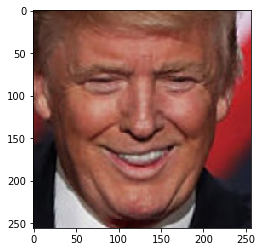

In [35]:
plt.imshow(input_img)

In [36]:
result_img, result_mask = swap_face(input_img, path_func)

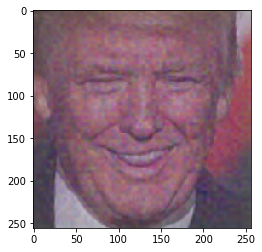

In [37]:
plt.imshow(result_img)

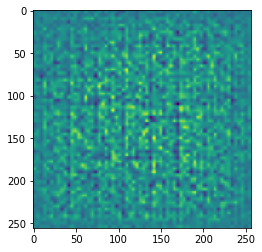

In [38]:
plt.imshow(result_mask[:, :, 0]) # cmap='gray'